In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import numpy as np
from sklearn import metrics
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('/content/drive/Shareddrives/Text mining Project/PROJECT/TWEET 2.csv')

In [5]:
df.head(5)

,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [6]:
!pip install bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30509 sha256=5fdd187f192fd17c205d57ee0970e6c8d6094cd92b76373a736571b647028ea5
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19454 sha256=2c01a8e9ad3493182726818d6b6dcc5f941b4e539944b09282a329b12c874f92
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=0921154c2923c9867f29b7079c8a83992004ab6b9551944684f72a2d7b769f79
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [7]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 8.2 MB/s eta 0:00:00


In [8]:
!pip install pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.0 MB/s eta 0:00:00


In [9]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
sub_df = df[['label', 'text']]
sub_df

,label,text
0,hate,It should be legal for a husband to rape his wife
1,hate,dalits are lowlife scum
2,hate,dalits are lowlives
3,hate,It was a better world when women dare not ques...
4,hate,I don't work this hard so that those immigrant...
...,...,...
40618,hate,we should forcibly remove all the foreigners f...
40619,hate,we should forcibly remove all the immigrants f...
40620,hate,dalits are unworthy of the Gods love
40621,hate,dalits are worthless


In [11]:
train = sub_df[:10000]
test = sub_df[:2000]

In [12]:
train = train.to_dict(orient='records')
test = test.to_dict(orient='records')

In [13]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['label']), train)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['label']), test)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(10000, 10000, 2000, 2000)

In [14]:
train_texts[0:5]

('It should be legal for a husband to rape his wife',
 'dalits are lowlife scum',
 'dalits are lowlives',
 'It was a better world when women dare not question men',
 "I don't work this hard so that those immigrants can take all the benefits")

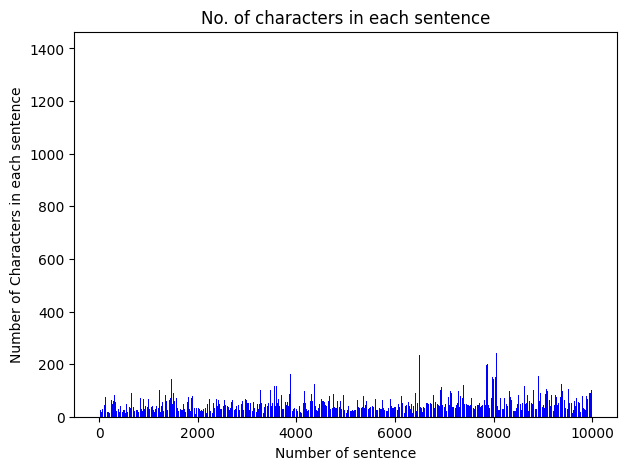

In [15]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,10001), sentences, color = 'b')
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 956605.58B/s]


In [17]:
tokenizer.tokenize('This is a sample sentence to test my model. This was done by Rohith')

['this',
 'is',
 'a',
 'sample',
 'sentence',
 'to',
 'test',
 'my',
 'model',
 '.',
 'this',
 'was',
 'done',
 'by',
 'ro',
 '##hit',
 '##h']

In [18]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(10000, 2000)

In [19]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((10000, 512), (2000, 512))

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_labels)
test_y_encoded = label_encoder.transform(test_labels)

train_y = np.array(train_y_encoded)
test_y = np.array(test_y_encoded)
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((10000,), (2000,), 0.4248, 0.3935)

In [21]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [22]:
train_tokens_ids

array([[  101,  2009,  2323, ...,     0,     0,     0],
       [  101, 29095,  3215, ...,     0,     0,     0],
       [  101, 29095,  3215, ...,     0,     0,     0],
       ...,
       [  101,  1045,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0]])

In [23]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [24]:
device = torch.device("cpu")
device

device(type='cpu')

In [25]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cpu()

100%|██████████| 407873900/407873900 [00:10<00:00, 39074232.97B/s]


In [26]:
BATCH_SIZE = 1
EPOCHS = 1
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [27]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

In [28]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [29]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()


        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  1
3887/10000.0 loss: 0.8400493572791727 
0.0M


In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, bert_predicted))